In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from pybaseball import statcast
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pybaseball import pitching_stats_bref
from pybaseball import statcast_batter

In [2]:
pyb.cache.enable()

In [3]:
data = statcast(start_dt="2023-03-30", end_dt="2023-10-24")
columns = ['game_date', 'player_name', 'batter', 'p_throws', 'stand', 'pitch_type', 'release_speed', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'spin_axis', 'effective_speed', 'release_spin_rate', 'release_extension', 'plate_x', 'plate_z', 'description']


This is a large query, it may take a moment to complete


100%|██████████| 209/209 [00:31<00:00,  6.55it/s]


In [4]:
df = data[columns]

# **Data Cleaning**

In [5]:
# Rename columns for easier access
column_mapping = {
    'game_date': 'date',
    'player_name': 'pitcher_name',
    'batter': 'batter_id',
    'p_throws': 'p_hand',
    'stand': 'batter_side',
    'pitch_type': 'pitch_type',
    'release_speed': 'velocity',
    'pfx_x': 'horizontal_break',
    'pfx_z': 'induced_vertical_break',
    'release_pos_x': 'release_side',
    'release_pos_y': 'release_dist_from_C',
    'release_pos_z': 'release_height',
    'spin_axis': 'spin_axis',
    'effective_speed': 'effective_velocity',
    'release_spin_rate': 'spin_rate',
    'release_extension': 'extension',
    'plate_x': 'pitch_height',
    'plate_z': 'pitch_side'
}

df.rename(columns=column_mapping, inplace=True)

c:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [6]:
# release side, release height, induced vertical break, extension, velocity, horizontal break, differential break, spin rate, spin axis
# pitcher name, pitcher team, pitch type

# Edit the pitcher names so the first name is first and the last name is last
df['pitcher_name'] = df['pitcher_name'].str.split(' ', expand=True)[1] + ' ' + df['pitcher_name'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
df['pitcher_name'] = df['pitcher_name'].replace(',', '', regex=True)

<ipython-input-6-630fba45d089>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitcher_name'] = df['pitcher_name'].str.split(' ', expand=True)[1] + ' ' + df['pitcher_name'].str.split(' ', expand=True)[0]
<ipython-input-6-630fba45d089>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitcher_name'] = df['pitcher_name'].replace(',', '', regex=True)


In [7]:
# Get a list of unique batter IDs in the dataframe
batter_ids = df['batter_id'].unique()

# Initialize an empty DataFrame to store the player names
df_batters = pd.DataFrame()

# Loop over the batter IDs and look up the player names
for batter_id in batter_ids:
    try:
        # Get data for the batter
        data = statcast_batter('2023-03-30', '2023-10-24', batter_id)
        
        # Get the player's name
        name = data['player_name'].iloc[0]
        
        # Append the batter ID and name to df_batters
        df_batters = df_batters.append({'batter_id': batter_id, 'name': name}, ignore_index=True)
    except:
        print(f"No player found for ID {batter_id}")

# Split the 'name' column into a DataFrame of separate words
name_df = df_batters['name'].str.split(' ', expand=True)

# Initialize an empty list to store the new names
new_names = []

# Loop over the rows in name_df
for i, row in name_df.iterrows():
    # If the name has only two words, use the existing method
    if row.count() == 2:
        new_name = row[1] + ' ' + row[0]
    # If the name has more than two words, use the other method
    else:
        first_name = row[row.last_valid_index()]
        last_name = ' '.join(row[:row.last_valid_index()].dropna())
        new_name = first_name + ' ' + last_name

    # Remove the comma from the new name
    new_name = new_name.replace(',', '')

    # Append the new name to new_names
    new_names.append(new_name)

# Replace the 'name' column in df_batters with new_names
df_batters['name'] = new_names


Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering 

,batter_id,name
0,595909.0,Jake Cave
1,669016.0,Brandon Marsh
2,592206.0,Nick Castellanos
3,682998.0,Corbin Carroll
4,606466.0,Ketel Marte


In [10]:
# Create a mapping from batter_id to name
batter_id_to_name = df_batters.set_index('batter_id')['name'].to_dict()

# Replace the batter_id values with names in the dataframe
df['batter_name'] = df['batter_id'].map(batter_id_to_name)

# Delete batter_id from the dataframe
df = df.drop('batter_id', axis=1)

In [15]:
print("Total hitters who played in 2023:", df['batter_name'].nunique())
print("Total pitchers who played in 2023:", df['pitcher_name'].nunique())
print("Total players who played in 2023:", df['batter_name'].nunique() + df['pitcher_name'].nunique())

Total hitters who played in 2023: 655
Total pitchers who played in 2023: 861
Total players who played in 2023: 1516


In [18]:
# Define a dictionary mapping different pitch types to standard ones
pitch_type_mapping = {
    'FF': 'FB',
    'FT': 'FB',
    'SI': 'FB',
    'FC': 'FB',
    'CH': 'CH',
    'FS': 'CH',
    'SC': 'CH',
    'GY': 'CH',
    'FO': 'CH',
    'FS': 'CH',
    'CU': 'CB',
    'KC': 'CB',
    'SL': 'SL'
}

# Replace the pitch types
df['pitch_type'] = df['pitch_type'].replace(pitch_type_mapping)
print(len(df))

# Remove pitch types that are not in the mapping
df = df[df['pitch_type'].isin(pitch_type_mapping.values())]
print(len(df))

df['pitch_type'].unique()

728284
690003


array(['FB', 'SL', 'CB', 'CH'], dtype=object)

In [20]:
# Make horizontal break the absolute value
df['horizontal_break'] = abs(df['horizontal_break'])

# Create differential break column: induced vertical break - horizontal break
df['differential_break'] = (df['induced_vertical_break'] - df['horizontal_break']).abs()

# Calculate the average fastball velocity and movement for each pitcher
average_fastball = df[df['pitch_type'] == 'FB'].groupby('pitcher_name')['velocity', 'horizontal_break', 'induced_vertical_break'].mean()

# Create new columns for the differences
df['velocity_diff'] = df['velocity'] - df['pitcher_name'].map(average_fastball['velocity'])
df['horizontal_break_diff'] = df['horizontal_break'] - df['pitcher_name'].map(average_fastball['horizontal_break'])
df['induced_vertical_break_diff'] = df['induced_vertical_break'] - df['pitcher_name'].map(average_fastball['induced_vertical_break'])

<ipython-input-20-8551bd8b0b96>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_fastball = df[df['pitch_type'] == 'FB'].groupby('pitcher_name')['velocity', 'horizontal_break', 'induced_vertical_break'].mean()


In [21]:
# Create columns for whiff (swing and miss) and swings
df['whiff'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == 'foul_tip' else 0)
df['swing'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == "hit_into_play" or x == "foul" or x == "foul_tip" else 0)

In [25]:
df_swing = df[df['swing'] == 1]
df_rhp_fb = df[(df['p_hand'] == 'R') & (df['pitch_type'] == 'FB')]

In [26]:
print("Difference between lengths of df and swing_df:", len(df) - len(df_swing))
print("Amount of swings and misses:", len(df_swing))
print("Total Fastballs thrown by RHP:", len(df_rhp_fb))

Difference between lengths of df and swing_df: 366628
Amount of swings and misses: 323375
Total Fastballs thrown by RHP: 296320


In [27]:
# Delete all nan values
df_swing = df_swing.dropna()
df_rhp_fb = df_rhp_fb.dropna()

df_swing_fb = df_swing[df_swing['pitch_type'] == 'FB']
df_swing_os = df_swing[df_swing['pitch_type'] != 'FB']

print("Amount of swings on fastballs: ", len(df_swing_fb))
print("Amount of swings on offspeed pitches: ", len(df_swing_os))
print("Total Fastballs thrown by RHP:", len(df_rhp_fb))

Amount of swings on fastballs:  189879
Amount of swings on offspeed pitches:  131496
Total Fastballs thrown by RHP: 294600


# **Feature Selection**

In [307]:
df_swing_fb_r_r = df_swing_fb[(df_swing_fb['p_hand'] == 'R') & (df_swing_fb['batter_side'] == 'R')]
print(len(df_swing_fb_r_r))

# Take a random sample of 10% of the fastballs
df_swing_fb_sample = df_swing_fb_r_r.sample(frac=0.1)


#X = df_swing_fb_sample[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_axis', 'effective_velocity', 'spin_rate', 'extension', 'pitch_height', 'pitch_side', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
X = df_swing_fb_sample[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'extension', 'differential_break']]
y = df_swing_fb_sample['whiff']

75687


In [308]:
# Assuming X is your feature matrix and y is the target variable
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{X.columns[sorted_indices[i]]}: {importances[sorted_indices[i]]}")

Feature ranking:
spin_rate: 0.14733435619540133
release_side: 0.12838265358502707
release_height: 0.1265094564059376
velocity: 0.12214455838129928
horizontal_break: 0.11949003454469653
induced_vertical_break: 0.11008178253912212
release_dist_from_C: 0.10728470874297136
differential_break: 0.1033379321180105
extension: 0.03543451748753428


First run with all pitches feature importances: 

pitch_side: 0.15918781968497506
pitch_height: 0.08908142654563922
velocity_diff: 0.07200292986109903
spin_rate: 0.0675649136154043
induced_vertical_break_diff: 0.06558167095284245
release_side: 0.06404723328752208
horizontal_break_diff: 0.0625597542981824
release_height: 0.061032218805417794
induced_vertical_break: 0.053478751471834965
spin_axis: 0.05107679885974624
release_dist_from_C: 0.04944773508657053
differential_break: 0.04942184003709487
horizontal_break: 0.048209646247451624
effective_velocity: 0.044949296324100885
velocity: 0.04427459388470133
extension: 0.018083371037417324

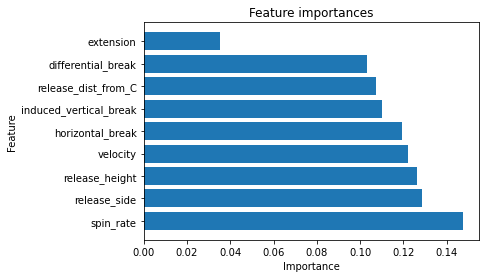

In [309]:
# Create a bar chart of feature importances
plt.barh(X.columns[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importances')
plt.show()

# **Running the Random Forest Model**

In [33]:
df_rhp_fb['velocity^2'] = df_rhp_fb['velocity']**2
df_rhp_fb['extension_IVB'] = df_rhp_fb['extension'] * df_rhp_fb['induced_vertical_break']
df_rhp_fb['spin_rate^3'] = df_rhp_fb['spin_rate']**3

In [34]:
#X = df_swing_fb[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_height', 'spin_rate', 'extension', 'differential_break']]
X = df_rhp_fb[['spin_rate^3', 'velocity', 'velocity^2', 'extension', 'induced_vertical_break', 'horizontal_break', 'release_side', 'release_height', 'spin_rate', 'differential_break', 'extension_IVB']]
y = df_rhp_fb['whiff']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
model = RandomForestRegressor(n_estimators=100, random_state=1)

model.fit(X_train, y_train)


RandomForestRegressor(random_state=1)

In [38]:
# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.09125743890020366
Random Forest R-squared score: -0.029378116830294898


In [39]:
# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                        importance
release_side              0.135235
release_height            0.122164
extension_IVB             0.113353
horizontal_break          0.098569
differential_break        0.094709
spin_rate                 0.084789
spin_rate^3               0.084676
induced_vertical_break    0.076720
extension                 0.064184
velocity                  0.063123
velocity^2                0.062478


# **XG Boost Model Training**

In [40]:
# XG Boost Model
df_rhp_fb['velocity^2'] = df_rhp_fb['velocity']**2
df_rhp_fb['extension_spin'] = df_rhp_fb['extension'] * df_rhp_fb['spin_rate']
df_rhp_fb['spin_rate^3'] = df_rhp_fb['spin_rate']**3
df_rhp_fb['IVB^3'] = df_rhp_fb['induced_vertical_break']**3
df_rhp_fb['HB^3'] = df_rhp_fb['horizontal_break']**3
df_rhp_fb['DB^2'] = df_rhp_fb['differential_break']**2
df_rhp_fb['velocity_feature'] = df_rhp_fb['velocity^2'] *  (df_rhp_fb['velocity']**3)

In [41]:
# Select the features and target variable
X = df_rhp_fb[['HB^3', 'velocity_feature', 'IVB^3', 'release_side', 'release_height', 'extension_spin', 'DB^2']]
y = df_rhp_fb['whiff']

In [42]:
#X = df_swing_fb_sample[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_axis', 'effective_velocity', 'spin_rate', 'extension', 'pitch_height', 'pitch_side', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object with the best parameters from the hyperparameter tuning
xgb_model = xgb.XGBRegressor(n_estimators=254, learning_rate=0.02521371583925624, max_depth=6, reg_alpha=1.0387116997045198, reg_lambda=0.47113390095546825, random_state=1)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

XGBoost Mean Squared Error: 0.08607785737339288
XGBoost R-squared score: 0.013074084426473842
                  importance
HB^3                0.238970
IVB^3               0.174796
velocity_feature    0.160280
release_height      0.118297
extension_spin      0.114055
release_side        0.102269
DB^2                0.091333


# **XG Boost Model Application**

In [67]:
# Predict xWhiff for all rows in the DataFrame
df_rhp_fb['xWhiff'] = xgb_model.predict(scaler.transform(df_rhp_fb[X.columns]))

# Scale the predictions so that the average is 100
df_rhp_fb['stuff_plus'] = (100 * df_rhp_fb['xWhiff'] / df_rhp_fb['xWhiff'].mean()).round(2)

df_rhp_fb['stuff_plus'].describe()

count    294600.000000
mean         99.998442
std          36.501550
min           3.820000
25%          71.990000
50%          96.760000
75%         119.860000
max         613.580000
Name: stuff_plus, dtype: float64

# **Results**

In [68]:
df_rhp_fb['p_hand'].unique()

array(['R'], dtype=object)

In [69]:
# Sort the DataFrame by 'Stuff+' values in descending order
df_sorted = df_rhp_fb.sort_values(by='stuff_plus', ascending=False)

# Reset the index of the sorted DataFrame
df_sorted.reset_index(drop=True, inplace=True)

df_sorted.head(20)

,date,pitcher_name,p_hand,batter_side,pitch_type,velocity,horizontal_break,induced_vertical_break,release_side,release_dist_from_C,...,velocity^2,extension_IVB,spin_rate^3,extension_spin,IVB^3,HB^3,DB^2,velocity_feature,xWhiff,stuff_plus
0,2023-08-12,Emmanuel Clase,R,R,FB,102.8,0.01,0.96,-0.56,53.41,...,10567.84,6.816,18736316416,18857.6,0.884736,0.000001,0.9025,11480626104.903679,0.605817,613.58
1,2023-03-30,Ryan Helsley,R,R,FB,100.5,0.27,1.85,-0.04,53.7,...,10100.25,12.58,21184951663,18815.6,6.331625,0.019683,2.4964,10252512531.28125,0.555311,562.43
2,2023-06-30,Camilo Doval,R,L,FB,102.4,0.45,1.11,-1.27,53.7,...,10485.76,7.548,15456856771,16938.8,1.367631,0.091125,0.4356,11258999068.426245,0.502113,508.55
3,2023-08-12,Emmanuel Clase,R,L,FB,102.4,0.04,0.96,-0.49,54.06,...,10485.76,6.144,18170704189,16825.6,0.884736,0.000064,0.8464,11258999068.426245,0.500112,506.52
4,2023-04-03,Ryne Nelson,R,R,FB,93.9,0.65,2.07,-0.68,53.79,...,8817.21,13.869,11666192832,15195.6,8.869743,0.274625,2.0164,7300085746.086992,0.493365,499.69
5,2023-04-30,Camilo Doval,R,R,FB,102.4,0.2,0.94,-1.9,54.27,...,10485.76,5.828,22857944472,17595.6,0.830584,0.008,0.5476,11258999068.426245,0.493347,499.67
6,2023-08-12,Emmanuel Clase,R,R,FB,102.8,0.14,0.85,-0.52,53.52,...,10567.84,5.95,19141296875,18725.0,0.614125,0.002744,0.5041,11480626104.903679,0.488648,494.91
7,2023-07-31,Félix Bautista,R,R,FB,100.5,0.64,1.89,0.29,53.66,...,10100.25,12.852,15050927709,16789.2,6.751269,0.262144,1.5625,10252512531.28125,0.485945,492.17
8,2023-08-13,Nate Pearson,R,R,FB,101.1,0.78,1.53,-0.77,53.59,...,10221.21,10.557,13945313143,16608.3,3.581577,0.474552,0.5625,10562233833.660507,0.483984,490.19
9,2023-08-23,Reynaldo López,R,L,FB,101.0,0.78,1.63,-1.75,53.96,...,10201.0,10.595,11883569768,14833.0,4.330747,0.474552,0.7225,10510100501.0,0.478741,484.88


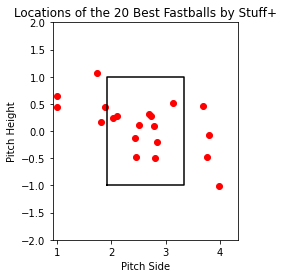

In [70]:
# Define the strike zone boundaries
sz_top = 1  
sz_bottom = -1

# The width of the strike zone is 17 inches, which is approximately 1.42 feet
# Since pitch_side is centered around 2.627, the left and right boundaries are 2.627 - 0.71 and 2.627 + 0.71
sz_left = 2.627 - 0.71
sz_right = 2.627 + 0.71

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the strike zone
ax.plot([sz_left, sz_right, sz_right, sz_left, sz_left], [sz_bottom, sz_bottom, sz_top, sz_top, sz_bottom], color='black')

# Plot the locations of the pitches
ax.scatter(df_sorted.head(20)['pitch_side'], df_sorted.head(20)['pitch_height'], color='red')

# Set the x and y axis limits to slightly larger than the strike zone
ax.set_xlim(sz_left - 1, sz_right + 1)
ax.set_ylim(sz_bottom - 1, sz_top + 1)

# Set the aspect of the plot to be equal, so the strike zone is square
ax.set_aspect('equal')

# Add labels and a title
ax.set_xlabel('Pitch Side')
ax.set_ylabel('Pitch Height')
ax.set_title('Locations of the 20 Best Fastballs by Stuff+')

# Show the plot
plt.show()

In [71]:
# Average Stuff+ for each possible pitch event
df_sorted.groupby(by='description')['stuff_plus'].mean().round(2)

description
ball                        98.89
blocked_ball                97.90
bunt_foul_tip              106.62
called_strike               95.13
foul                       101.94
foul_bunt                   91.85
foul_tip                   116.16
hit_by_pitch                89.68
hit_into_play               94.17
missed_bunt                 84.60
swinging_strike            120.56
swinging_strike_blocked    130.45
Name: stuff_plus, dtype: float64

In [85]:
top_20 = df_sorted.head(20)
top_20[['induced_vertical_break', 'horizontal_break', 'differential_break']] = top_20[['induced_vertical_break', 'horizontal_break', 'differential_break']] * 12
top_20[['stuff_plus', 'pitcher_name', 'batter_name', 'date', 'description', 'velocity', 'spin_rate', 'induced_vertical_break', 'horizontal_break', 'differential_break']].head(30)


c:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,stuff_plus,pitcher_name,batter_name,date,description,velocity,spin_rate,induced_vertical_break,horizontal_break,differential_break
0,613.58,Emmanuel Clase,Randy Arozarena,2023-08-12,swinging_strike,102.8,2656,11.52,0.12,11.4
1,562.43,Ryan Helsley,Bo Bichette,2023-03-30,swinging_strike,100.5,2767,22.2,3.24,18.96
2,508.55,Camilo Doval,Brandon Nimmo,2023-06-30,swinging_strike,102.4,2491,13.32,5.4,7.92
3,506.52,Emmanuel Clase,Wander Franco,2023-08-12,swinging_strike,102.4,2629,11.52,0.48,11.04
4,499.69,Ryne Nelson,Xander Bogaerts,2023-04-03,swinging_strike,93.9,2268,24.84,7.8,17.04
5,499.67,Camilo Doval,Nelson Cruz,2023-04-30,swinging_strike,102.4,2838,11.28,2.4,8.88
6,494.91,Emmanuel Clase,Randy Arozarena,2023-08-12,swinging_strike,102.8,2675,10.2,1.68,8.52
7,492.17,Félix Bautista,Danny Jansen,2023-07-31,swinging_strike,100.5,2469,22.68,7.68,15.0
8,490.19,Nate Pearson,Nick Madrigal,2023-08-13,swinging_strike,101.1,2407,18.36,9.36,9.0
9,484.88,Reynaldo López,TJ Friedl,2023-08-23,swinging_strike,101.0,2282,19.56,9.36,10.2


# Top 5 RHP Fastballs by Stuff+ (Find videos on Statcast):
Emmanuel Clase vs. Randy Arozarena, 8/12, 102.8 mph  
Ryan Helsley vs. Bo Bichette, 3/30, 100.5 MPH  
Camilo Doval vs. Brandon Nimmo, 6/30, 102.4 MPH  
Emmanuel Clase vs. Wander Franco, 8/12, 102.4 MPH  
Ryne Nelson vs. Xander Bogaerts, 4/3, 93.9 MPH  

Best by a starter:  
Jacob Degrom vs. Ryan Noda, 4/23, 101 MPH  
Justin Verlander vs. Everson Pereira, 9/1, 94.2 MPH  
Maybe more?

In [50]:
average_fb_Stuff = df_sorted.groupby('pitcher_name')['stuff_plus'].mean()
average_fb_Stuff = average_fb_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff.sort_values(ascending=False)

average_fb_Stuff_sorted

pitcher_name
Félix Bautista       201.04
Jhoan Duran          193.14
Robert Stephenson    175.83
Hunter Harvey        172.58
Jacob deGrom         168.34
                      ...  
Bryce Elder           57.40
Michael Mariot        56.23
Brandon Crawford      51.73
Darren McCaughan      50.27
Kyle Hendricks        50.27
Name: stuff_plus, Length: 589, dtype: float64

# Which hitters faced the best fastball Stuff+ from RHP?

In [82]:
# Count the number of pitches each batter has seen
pitch_count = df_sorted.groupby('batter_name')['stuff_plus'].count()

# Add the pitch count to the DataFrame
average_fb_Stuff = df_sorted.groupby('batter_name')['stuff_plus'].mean().reset_index()
average_fb_Stuff['pitch_count'] = pitch_count.values
average_fb_Stuff = average_fb_Stuff.round(2)

# Filter the DataFrame
average_fb_Stuff_filtered = average_fb_Stuff[average_fb_Stuff['pitch_count'] >= 50]

# Sort the DataFrame in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff_filtered.sort_values(by='stuff_plus', ascending=False)

top_10 = average_fb_Stuff_sorted.iloc[:10]
bottom_10 = average_fb_Stuff_sorted.iloc[-10:]

In [83]:
# It would be interesting to find their batting average against fastballs vs. their stuff+ faced. 
# Likely negative correlation btwn BA and Stuff+ (stuff on x-axis)
print(top_10)
print("-----------------------------------------")
print(bottom_10)

             batter_name  stuff_plus  pitch_count
103  Canaan Smith-Njigba      124.25           68
323         Jordyn Adams      119.35           59
278          Jared Walsh      118.63          221
239      Heston Kjerstad      118.14           58
490           Oneil Cruz      117.77           52
598       Tyler Heineman      116.65           98
162        David Hensley      114.79          155
494      Osleivis Basabe      114.44          123
31      Andrew Stevenson      114.27           53
466         Nathan Lukes      113.79           55
-----------------------------------------
        batter_name  stuff_plus  pitch_count
419      Masyn Winn       88.17          230
347     José Fermín       87.77          101
438  Michael Chavis       87.67           67
150      Dane Myers       86.54          106
577      Tomás Nido       86.48           50
519     Riley Adams       85.79          153
312  Jonathan Araúz       84.50           99
634   Yonathan Daza       82.84          119
250

# **Hyperparameter Tuning**

In [291]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 7),
    'reg_alpha': uniform(0.1, 1.0),
    'reg_lambda': uniform(0.1, 1.0)
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=1)

# Create the random search object
random_search = RandomizedSearchCV(xgb_model, param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=1)

# Fit the random search object to the data
random_search.fit(X, y)

# Print the best parameters
print(random_search.best_params_)

KeyboardInterrupt: 

'learning_rate': 0.02521371583925624, 'max_depth': 6, 
'n_estimators': 254, 
'reg_alpha': 1.0387116997045198, 'reg_lambda': 0.47113390095546825

In [ ]:
"""
# List of features to include
features = ['HB^3', 'velocity^2', 'IVB^3', 'release_side', 'release_height', 'extension_spin', 'diff_break_bin_high']

# Train and evaluate the model with the diff_break_bin_high feature
X_with = df_swing_fb[features]
X_train_with, X_test_with, y_train, y_test = train_test_split(X_with, y, test_size=0.2, random_state=1)
X_train_scaled_with = scaler.fit_transform(X_train_with)
X_test_scaled_with = scaler.transform(X_test_with)
xgb_model_with = xgb.XGBRegressor(n_estimators=181, learning_rate=0.029515477895583855, random_state=1)
xgb_model_with.fit(X_train_scaled_with, y_train)
y_pred_with = xgb_model_with.predict(X_test_scaled_with)
mse_with = mean_squared_error(y_test, y_pred_with)
r2_with = r2_score(y_test, y_pred_with)

# List of features to include
features = ['HB^3', 'velocity^2', 'IVB^3', 'release_side', 'release_height', 'extension_spin']

# Train and evaluate the model without the diff_break_bin_high feature
X_without = df_swing_fb[features]
X_train_without, X_test_without, y_train, y_test = train_test_split(X_without, y, test_size=0.2, random_state=1)
X_train_scaled_without = scaler.fit_transform(X_train_without)
X_test_scaled_without = scaler.transform(X_test_without)
xgb_model_without = xgb.XGBRegressor(n_estimators=181, learning_rate=0.029515477895583855, random_state=1)
xgb_model_without.fit(X_train_scaled_without, y_train)
y_pred_without = xgb_model_without.predict(X_test_scaled_without)
mse_without = mean_squared_error(y_test, y_pred_without)
r2_without = r2_score(y_test, y_pred_without)

# Print the results
print("With diff_break_bin_high:")
print("Mean Squared Error:", mse_with)
print("R-squared score:", r2_with)
print("\nWithout diff_break_bin_high:")
print("Mean Squared Error:", mse_without)
print("R-squared score:", r2_without)
"""

'\n# List of features to include\nfeatures = [\'HB^3\', \'velocity^2\', \'IVB^3\', \'release_side\', \'release_height\', \'extension_spin\', \'diff_break_bin_high\']\n\n# Train and evaluate the model with the diff_break_bin_high feature\nX_with = df_swing_fb[features]\nX_train_with, X_test_with, y_train, y_test = train_test_split(X_with, y, test_size=0.2, random_state=1)\nX_train_scaled_with = scaler.fit_transform(X_train_with)\nX_test_scaled_with = scaler.transform(X_test_with)\nxgb_model_with = xgb.XGBRegressor(n_estimators=181, learning_rate=0.029515477895583855, random_state=1)\nxgb_model_with.fit(X_train_scaled_with, y_train)\ny_pred_with = xgb_model_with.predict(X_test_scaled_with)\nmse_with = mean_squared_error(y_test, y_pred_with)\nr2_with = r2_score(y_test, y_pred_with)\n\n# List of features to include\nfeatures = [\'HB^3\', \'velocity^2\', \'IVB^3\', \'release_side\', \'release_height\', \'extension_spin\']\n\n# Train and evaluate the model without the diff_break_bin_high fea

In [ ]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid\nparam_grid = {\n    \'n_estimators\': [50, 100, 150, 200],\n    \'learning_rate\': [0.01, 0.1, 0.2, 0.3]\n}\n\n# Create the GridSearchCV object\ngrid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train_scaled, y_train)\n\n# Print the best parameters and the best score\nprint("Best parameters:", grid_search.best_params_)\nprint("Best score:", grid_search.best_score_)\n\n# Use the best estimator to make predictions\ny_pred = grid_search.best_estimator_.predict(X_test_scaled)\n\n# Evaluate the model\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint("Mean Squared Error:", mse)\nprint("R-squared score:", r2)\n'

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use the best estimator to make predictions
y_pred = random_search.best_estimator_.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint, uniform\n\n# Define the parameter distribution\nparam_dist = {\n    \'n_estimators\': randint(50, 200),\n    \'learning_rate\': uniform(0.01, 0.3)\n}\n\n# Create the RandomizedSearchCV object\nrandom_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_dist, n_iter=50, cv=5, scoring=\'neg_mean_squared_error\', random_state=42)\n\n# Fit the RandomizedSearchCV object to the data\nrandom_search.fit(X_train_scaled, y_train)\n\n# Print the best parameters and the best score\nprint("Best parameters:", random_search.best_params_)\nprint("Best score:", random_search.best_score_)\n\n# Use the best estimator to make predictions\ny_pred = random_search.best_estimator_.predict(X_test_scaled)\n\n# Evaluate the model\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint("Mean Squared Error:", mse)\nprint("R-squared score:", r2)\n'

Best parameters: {'learning_rate': 0.029515477895583855, 'n_estimators': 181}
Best score: -0.1588402246170339
Mean Squared Error: 0.1595497477178634
R-squared score: 0.02342727228548369